In [1]:
import sys
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm, uniform

In [2]:
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color="black",
                 noise_per_meter=5, noise_std=math.pi/60,
                 bias_rate_stds=(0.1, 0.1), 
                 expected_stuck_time=1e100, expected_escape_time = 1e-100,
                 expected_kidnap_time=1e100, kidnap_range_x=(-5.0, 5.0), kidnap_range_y=(-5.0, 5.0)):  
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))   # 指数分布(最初に小石を踏むまでの距離を計算)
        self.distance_until_noise = self.noise_pdf.rvs()               # 小石を踏むまでの距離をドロー
        self.theta_noise = norm(scale=noise_std)                       # θに加える雑音をドロー
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])      # バイアスの決定
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1])
        
        self.stuck_pdf = expon(scale=expected_stuck_time)              # スタックするまでの時間を決める確率密度関数
        self.escape_pdf = expon(scale=expected_escape_time)            # スタックから脱するまでの時間を決める確率密度関数
        self.time_until_stuck = self.stuck_pdf.rvs()                   # ドロー
        self.time_until_escape = self.escape_pdf.rvs()
        self.is_stuck = False                                          # スタックしているか否かを表すフラグ
        
        self.kidnap_pdf = expon(scale=expected_kidnap_time)            # 誘拐するまでの時間を決める確率密度関数
        self.time_until_kidnap = self.kidnap_pdf.rvs()                 
        rx, ry = kidnap_range_x, kidnap_range_y                    
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi)) # 誘拐後の姿勢の一様分布
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval  # 移動ごとに次の小石までの距離を減らしていく
        if self.distance_until_noise <= 0.0:            # 小石を踏んだか判定、次の小石までの距離と加えるノイズの量を決める
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
    
    def bias(self, nu, omega):                          # nu, omegaに決定したバイアスをかけて返す処理
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:                                           # スタックしているとき
            self.time_until_escape -= time_interval                 # 　脱出までの時間を減らしていく
            if self.time_until_escape <= 0.0:                       # 　スタックから脱出できるようになったら
                self.time_until_escape += self.escape_pdf.rvs()     # 　　次のスタック脱出時間を決定
                self.is_stuck = False                               #　 　スタック状態を解除
        else:                                                       # スタックしていないとき 
            self.time_until_stuck -= time_interval                  # 　スタックするまでの時間を減らしていく
            if self.time_until_stuck <= 0.0:                        # 　スタックする時間になったら
                self.time_until_stuck += self.stuck_pdf.rvs()       # 　　次にスタックするまでの時間を決定
                self.is_stuck = True                                # 　　スタック状態に
        
        return nu*(not self.is_stuck), omega*(not self.is_stuck)    # スタック状態のときは0を返す
    
    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -= time_interval                     # 誘拐までの時間を減らしていく
        if self.time_until_kidnap <= 0.0:                           # 誘拐の時間になったとき
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T               # 新しい姿勢を一様分布からドローして返す
        else:
            return pose
    
    def one_step(self, time_interval):
        if not self.agent: return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)                               # nu, omegaをバイアスがかかったものにする
        nu, omega = self.stuck(nu, omega, time_interval)               # nu, omegaをスタックさせる
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)    # ノイズが乗るように追加(one_stepごとにnoise計算)
        self.pose = self.kidnap(self.pose, time_interval)              # 誘拐を加える

In [3]:
class Camera(IdealCamera):
    def __init__(self, env_map, distance_range=(0.5, 6.0), direction_range=(-math.pi/3, math.pi/3), 
                 distance_noise_rate=0.1, direction_noise=math.pi/90, 
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90,
                 phantom_prob=0.0, phantom_range_x=(-5.0, 5.0), phantom_range_y=(-5.0, 5.0),
                 oversight_prob=0.1):
        
        super().__init__(env_map, distance_range, direction_range)
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise
        self.distance_bias_rate_std = norm.rvs(scale=distance_bias_rate_stddev)     # 距離に加えるバイアス（の割合）をドロー
        self.direction_bias = norm.rvs(scale=direction_bias_stddev)                 # 角度に加えるバイアスをドロー
        
        rx, ry = phantom_range_x, phantom_range_y
        self.phantom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]-rx[0], ry[1]-ry[0]))    # ファントム(間違ったランドマーク)の位置の一様分布
        self.phantom_prob = phantom_prob                                            # 各ランドマークのファントムが出現する割合
        self.oversight_prob = oversight_prob                                        # 各ランドマークを見落とす割合
        
    def noise(self, relpos):
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)     # センサ値relposを読み取り、雑音を混入する
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos):
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std, self.direction_bias]).T  # センサ値にバイアスを足す（距離バイアスは距離に比例）
    
    def phantom(self, cam_pose, relpos):
        if uniform.rvs() < self.phantom_prob:                 # 一様分布からドローした値がprobを下回ったとき（ファントムになるとき）
            pos = np.array(self.phantom_dist.rvs()).T
            return self.observation_function(cam_pose, pos)   # ファントムとカメラの相対位置を返す
        else:
            return relpos                                     # もともとの相対位置を返す
        
    def oversight(self, relpos):
        if uniform.rvs() < self.oversight_prob:               # 見落としが起きるとき
            return None                                       # 値(相対位置)を返さない
        else:
            return relpos
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z)             # ファントムを出す
            z = self.oversight(z)
            if self.visible(z):
                z = self.bias(z)                      # バイアスを加える
                z = self.noise(z)                     # 雑音を混入
                observed.append((z, lm.id))
            
        self.lastdata = observed
        return observed

<IPython.core.display.Javascript object>


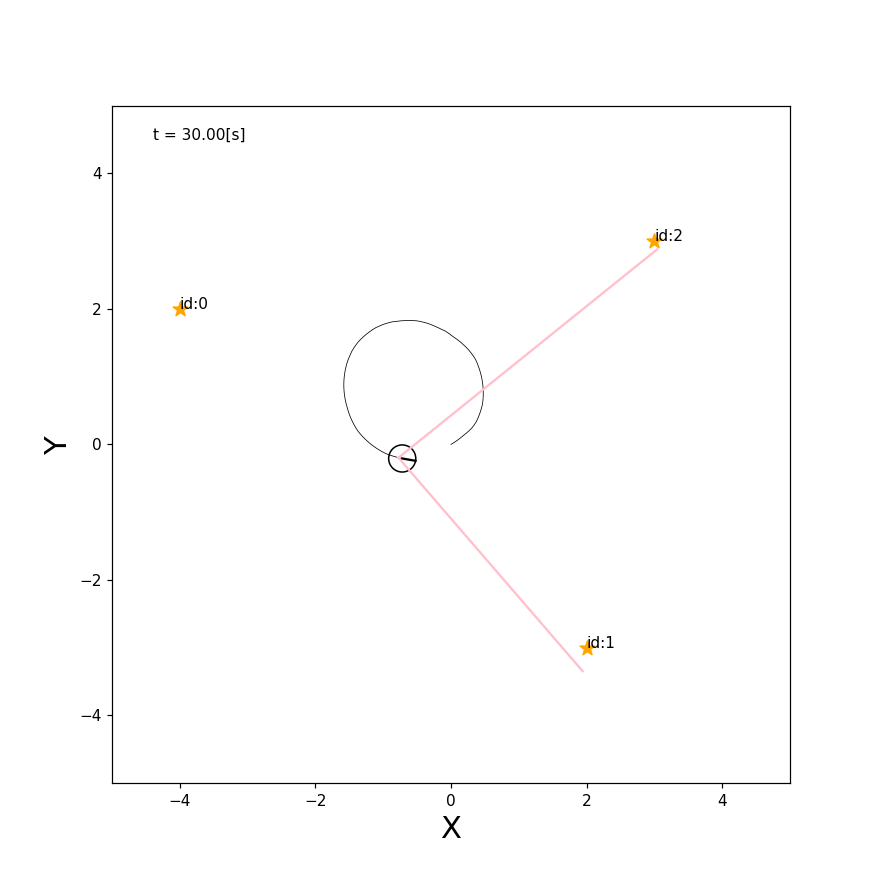

In [4]:
world = World(30, 0.3, debug=False)

# 地図を作成してランドマークを追加
m = Map()
m.append_landmark(LandMark(-4, 2))
m.append_landmark(LandMark(2, -3))
m.append_landmark(LandMark(3, 3))
world.append(m)

# ロボットを作る
straight = Agent(0.2, 0.0)
circling = Agent(0.2, 10.0/180*math.pi)
r = Robot(np.array([0, 0, math.pi/6]).T, sensor=Camera(m), agent=circling)
world.append(r)
    
# アニメーション実行
world.draw()